# Autoencoder for time series

## Notebook settings

In [1]:
%config IPCompleter.greedy=True
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [120]:
# %load -s loadData ../scripts/dataUtilities.py 
def loadData(direc, dataset, perm=True, ratio_train=0.8):
    datadir = direc + '/' + dataset + '/' + dataset
    data_train = np.genfromtxt(datadir + '_TRAIN.tsv', delimiter='\t')
    data_test_val = np.genfromtxt(datadir + '_TEST.tsv', delimiter='\t')[:-1]
    data = np.concatenate((data_train, data_test_val), axis=0)

    N, D = data.shape
    ind_cut = int(ratio_train * N)
    if perm:
        ind = np.random.permutation(N)
    else:
        ind = range(0, N)
    return data[ind[:ind_cut], 1:], data[ind[ind_cut:], 1:], data[ind[:ind_cut], 0], data[ind[ind_cut:], 0]


In [175]:
# %load -s outlier_annihilation ../scripts/dataUtilities.py 
def outlier_annihilation(dataset):
    df = pd.DataFrame(dataset)
    for col in df:
        low_threshold = df[col].quantile(0.03)
        high_threshold = df[col].quantile(0.97)
        df.loc[df[col] < low_threshold, col] = low_threshold
        df.loc[df[col] > high_threshold, col] = high_threshold
    return df.to_numpy()


## Cleaning and plotting of training set

In [ ]:
dataTrain, dataTest, labelsTrain, labelsTest = loadData('../data/UCRArchive_2018', 'ECG5000', perm=False)

# TODO: -2 and 6 to be changed to other values, maybe percentiles
dataTrain = outlier_annihilation(dataTrain)
dataTest = outlier_annihilation(dataTest)
pd.DataFrame(dataTrain).plot(legend=False)
pd.DataFrame(dataTest).plot(legend=False)

## Configuration hyperparameter

In [4]:
config = dict()  # Put all configuration information into the dict
config['num_layers'] = 2  # number of layers of stacked RNN's
config['hidden_size'] = 90  # memory cells in a layer
config['max_grad_norm'] = 5  # maximum gradient norm during training
config['batch_size'] = batch_size = 64 # number of samples for iteration
config['learning_rate'] = .005 # for exponential decay
config['crd'] = 1  # Hyperparameter for future generalization
config['num_l'] = 32 # number of units in the latent space

plot_every = 100  # after _plot_every_ GD steps, there's console output
max_iterations = 1000  # maximum number of iterations
dropout = 0.8 # Dropout rate

## Valuate sequence length

In [5]:
N = dataTrain.shape[0]
Nval = dataTest.shape[0]
D = dataTrain.shape[1]
config['sl'] = sl = D  # sequence length
print('We have %s observations with %s dimensions' % (N+1, D))

We have 3445 observations with 166 dimensions


## Valuate class number and min class

In [6]:
num_classes = len(np.unique(labelsTrain))
base = np.min(labelsTrain)  # Check if data is 0-based
if base != 0:
    labelsTrain -= base
    labelsTest -= base

print('We have %s classes, %s is the min class value' % (num_classes, base))

We have 3 classes, 1.0 is the min class value


In [7]:
import matplotlib.pyplot as plt
from collections import Counter

# %load -s plot_data ../scripts/plotUtilities.py 
def plot_data(data, classes, plot_row=10, save = False, name = 'tmp', adjust=True):
    counts = dict(Counter(classes))
    uniqueClasses = np.unique(classes)
    num_classes = len(uniqueClasses)
    f, axarr = plt.subplots(plot_row, num_classes)
    for selectedClass in uniqueClasses:  # Loops over classes, plot as columns
        selectedClass = int(selectedClass)
        ind = np.where(classes == selectedClass)
        ind_plot = np.random.choice(ind[0], size=plot_row)
        for n in range(plot_row):  # Loops over rows
            # Only shops axes for bottom row and left column
            if n == 0:
                axarr[n, selectedClass].set_title('Class %.0f (%.0f elements)' % (selectedClass + 1, counts[float(selectedClass)]))
            if n < counts[float(selectedClass)]:
                axarr[n, selectedClass].plot(data[ind_plot[n], :])

                if not n == plot_row - 1:
                    plt.setp([axarr[n, selectedClass].get_xticklabels()], visible=False)
                if not selectedClass == 0:
                    plt.setp([axarr[n, selectedClass].get_yticklabels()], visible=False)
    
    if adjust == True:
        f.subplots_adjust(hspace=0)  # No horizontal space between subplots
        f.subplots_adjust(wspace=0)  # No vertical space between subplots
    plt.show()

    if save:
        plt.savefig(name, format='png', dpi=1000)
        
    return


## Data class plot

Populating the interactive namespace from numpy and matplotlib


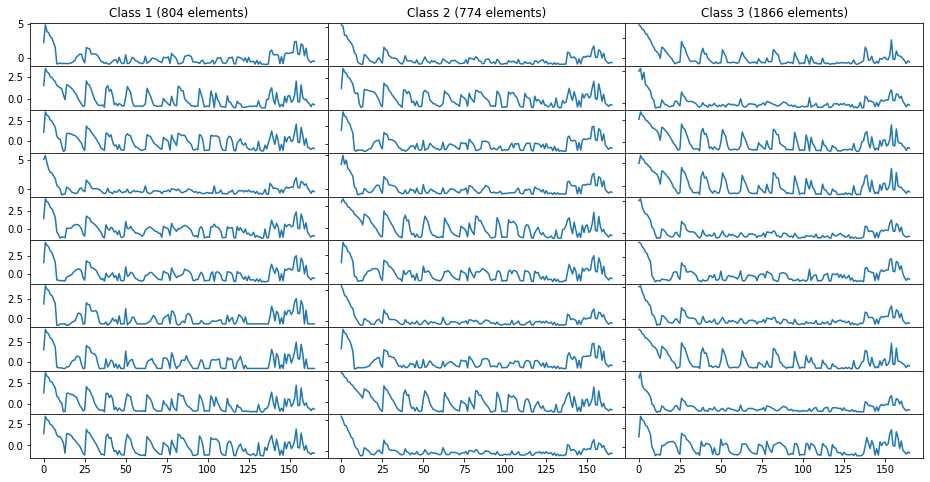

In [8]:
%pylab inline
pylab.rcParams['figure.figsize'] = (16, 8)

plot_data(dataTrain, labelsTrain)
# plot_data(dataTrain, labelsTrain, 5, True, "Prova.eps")

# Training time

## Net definition

### Net description
**dropout**: A single model can be used to simulate having a large number of different network architectures by randomly dropping out nodes during training. This is called dropout and offers a very computationally cheap and remarkably effective regularization method to reduce overfitting and improve generalization error in deep neural networks of all kinds.


In [9]:
import tensorflow as tf
from tensorflow.nn.rnn_cell import LSTMCell
import tensorflow_probability as tfp
tf.logging.set_verbosity(tf.logging.ERROR)

class Model:
    def __init__(self, config):
        # Hyperparameters of the net
        num_layers = config['num_layers']
        hidden_size = config['hidden_size']
        max_grad_norm = config['max_grad_norm']
        batch_size = config['batch_size']
        sl = config['sl']
        crd = config['crd']
        num_l = config['num_l']
        learning_rate = config['learning_rate']
        self.sl = sl
        self.batch_size = batch_size

        # Nodes for the input variables
        self.x = tf.placeholder("float", shape=[batch_size, sl], name='Input_data')
        self.x_exp = tf.expand_dims(self.x, 1)
        self.keep_prob = tf.placeholder("float")

        with tf.variable_scope("Encoder"):
            # Th encoder cell, multi-layered with dropout
            # Number of LSTM = hidden layer size
            cell_enc = tf.contrib.rnn.MultiRNNCell([LSTMCell(hidden_size) for _ in range(num_layers)])
            cell_enc = tf.contrib.rnn.DropoutWrapper(cell_enc, output_keep_prob=self.keep_prob)

            # Initial state, tuple for all lstms stacked
            initial_state_enc = cell_enc.zero_state(batch_size, tf.float32)

            # layer for mean of z
            W_mu = tf.get_variable('W_mu', [hidden_size, num_l])

            # Creates a recurrent neural network specified by RNNCell cell
            # outputs is a length T list of outputs (one for each input), or a nested tuple of such elements.
            # in our case one output for each time series in input
            outputs_enc, _ = tf.contrib.rnn.static_rnn(cell_enc,
                                                       inputs=tf.unstack(self.x_exp, axis=2),
                                                       initial_state=initial_state_enc)
            cell_output = outputs_enc[-1]
            b_mu = tf.get_variable('b_mu', [num_l])

            # self.z_mu is the Tensor containing the hidden representations
            # It can be used to do visualization, clustering or subsequent classification
            # tf.nn.xw_plus_b computes matmul(x, weights) + biases.
            self.z_mu = tf.nn.xw_plus_b(cell_output, W_mu, b_mu, name='z_mu')  # mu, mean, of latent space

            # Calculate the mean and variance of the latent space
            # The mean and variance are calculated by aggregating the contents of z_mu across axes
            lat_mean, lat_var = tf.nn.moments(self.z_mu, axes=[1])

            # Train the point in latent space to have zero-mean and unit-variance on batch basis
            self.loss_lat_batch = tf.reduce_mean(tf.square(lat_mean) + lat_var - tf.log(lat_var) - 1)

        with tf.name_scope("Lat_2_dec"):
            # layer to generate initial state
            W_state = tf.get_variable('W_state', [num_l, hidden_size])
            b_state = tf.get_variable('b_state', [hidden_size])
            z_state = tf.nn.xw_plus_b(self.z_mu, W_state, b_state, name='z_state')  # mu, mean, of latent space

        # Similar steps as encoder
        with tf.variable_scope("Decoder"):
            # The decoder, also multi-layered
            cell_dec = tf.contrib.rnn.MultiRNNCell([LSTMCell(hidden_size) for _ in range(num_layers)])

            # Initial state
            initial_state_dec = tuple([(z_state, z_state)] * num_layers)
            dec_inputs = [tf.zeros([batch_size, 1])] * sl

            outputs_dec, _ = tf.contrib.rnn.static_rnn(cell_dec,
                                                       inputs=dec_inputs,
                                                       initial_state=initial_state_dec)
        with tf.name_scope("Out_layer"):
            params_o = 2 * crd  # Number of coordinates + variances
            W_o = tf.get_variable('W_o', [hidden_size, params_o])
            b_o = tf.get_variable('b_o', [params_o])
            outputs = tf.concat(outputs_dec, axis=0)  # tensor in [sl*batch_size,hidden_size]
            h_out = tf.nn.xw_plus_b(outputs, W_o, b_o)
            h_mu, h_sigma_log = tf.unstack(tf.reshape(h_out, [sl, batch_size, params_o]), axis=2)
            h_sigma = tf.exp(h_sigma_log)
            dist = tfp.distributions.Normal(h_mu, h_sigma)
            px = dist.log_prob(tf.transpose(self.x))
            loss_seq = -px
            self.loss_seq = tf.reduce_mean(loss_seq)

        with tf.name_scope("train"):
            global_step = tf.Variable(0, trainable=False)
            # Use learning rate decay
            # Useful use a learning rate schedule to reduce learning rate as the training progresses. 
            lr = tf.train.exponential_decay(learning_rate, global_step, 1000, 0.1, staircase=False)

            self.loss = self.loss_seq + self.loss_lat_batch

            # Route the gradients
            tvars = tf.trainable_variables()
            # We clip the gradients to prevent explosion
            grads = tf.gradients(self.loss, tvars)
            grads, _ = tf.clip_by_global_norm(grads, max_grad_norm)
            self.numel = tf.constant([[0]])

            # And apply the gradients
            optimizer = tf.train.AdamOptimizer(lr)
            gradients = zip(grads, tvars)
            self.train_step = optimizer.apply_gradients(gradients, global_step=global_step)

            self.numel = tf.constant([[0]])
            
        tf.summary.tensor_summary('lat_state', self.z_mu)
        # Define one op to call all summaries
        self.merged = tf.summary.merge_all()
        # and one op to initialize the variables
        self.init_op = tf.global_variables_initializer()

## Training model

In [10]:
import os

model = Model(config)
sess = tf.Session()
perf_collect = np.zeros((2, int(np.ceil(max_iterations / plot_every)+1)))

batch_size = config['batch_size']
# Needed later for testing K-means
actual_test_size = (Nval // batch_size) * batch_size
actual_dataTest = dataTest[0:actual_test_size]
actual_labelsTest = labelsTest[0:actual_test_size]

# Start of the train
epochs = np.floor(batch_size * max_iterations / N)

print('Train with approximately %d epochs' % epochs)

sess.run(model.init_op)

step = 0  # Step is a counter for filling the numpy array perf_collect
for i in range(max_iterations):
    batch_ind = np.random.choice(N, batch_size, replace=False)
    result = sess.run([model.loss, model.loss_seq, model.loss_lat_batch, model.train_step],
                      feed_dict={model.x: dataTrain[batch_ind], model.keep_prob: dropout})
    
    if (i == 0) or (((i+1) % plot_every) == 0):
        # Save train performances
        perf_collect[0, step] = loss_train = result[0]
        loss_train_seq, lost_train_lat = result[1], result[2]

        # Calculate and save validation performance
        batch_ind_val = np.random.choice(Nval, batch_size, replace=False)

        result = sess.run([model.loss, model.loss_seq, model.loss_lat_batch, model.merged],
                          feed_dict={model.x: dataTest[batch_ind_val], model.keep_prob: 1.0})
        perf_collect[1, step] = loss_val = result[0]
        loss_val_seq, lost_val_lat = result[1], result[2]
        # and save to Tensorboard
        summary_str = result[3]

        print("At %6s / %6s train (%5.3f, %5.3f, %5.3f), val (%5.3f, %5.3f,%5.3f) in order (total, seq, lat)" % (
        i+1, max_iterations, loss_train, loss_train_seq, lost_train_lat, loss_val, loss_val_seq, lost_val_lat))
        step += 1
    
saver = tf.train.Saver()
saver.save(sess, os.path.join("logs/ecg5000.ckpt"), step)

print("model trained, saved in logs directory")

Train with approximately 18 epochs
At      1 /   1000 train (4.907, 2.556, 2.351), val (3.695, 1.861,1.834) in order (total, seq, lat)
At    100 /   1000 train (1.023, 1.019, 0.004), val (1.005, 1.005,0.000) in order (total, seq, lat)
At    200 /   1000 train (0.775, 0.769, 0.006), val (0.750, 0.749,0.001) in order (total, seq, lat)
At    300 /   1000 train (0.608, 0.603, 0.005), val (0.600, 0.600,0.001) in order (total, seq, lat)
At    400 /   1000 train (0.758, 0.749, 0.010), val (0.736, 0.727,0.009) in order (total, seq, lat)
At    500 /   1000 train (0.689, 0.683, 0.007), val (0.715, 0.714,0.001) in order (total, seq, lat)
At    600 /   1000 train (0.642, 0.637, 0.005), val (0.675, 0.673,0.001) in order (total, seq, lat)
At    700 /   1000 train (0.622, 0.617, 0.005), val (0.639, 0.639,0.000) in order (total, seq, lat)
At    800 /   1000 train (0.480, 0.476, 0.004), val (0.527, 0.526,0.001) in order (total, seq, lat)
At    900 /   1000 train (0.371, 0.365, 0.006), val (0.478, 0.477

'logs/ecg5000.ckpt-11'

model trained, saved in logs directory


## Get latent vector from model run on dataTest

In [11]:
saver = tf.train.Saver()
saver.restore(sess, save_path=os.path.join("logs/ecg5000.ckpt-11"))
start = 0
label = []  # The label to save to visualize the latent space
z_run = []

while start + batch_size < Nval:
    run_ind = range(start, start + batch_size)
    z_mu_fetch = sess.run(model.z_mu, feed_dict={model.x: dataTest[run_ind], model.keep_prob: 1.0})
    z_run.extend(z_mu_fetch.tolist())
    start += batch_size

## Plot entire test set on labels

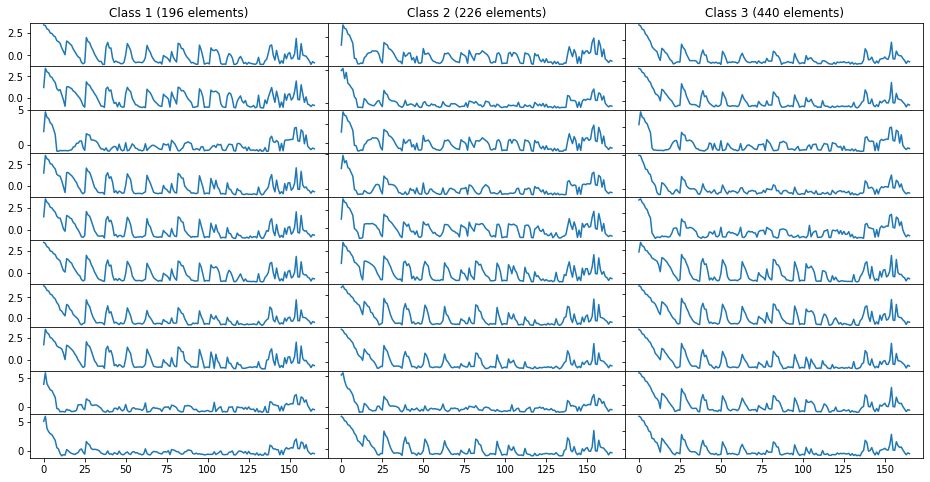

In [12]:
pylab.rcParams['figure.figsize'] = (16, 8)
plot_data(dataTest, labelsTest)

## Clustering based on latent vector of net

In [21]:
from sklearn.cluster import KMeans
from itertools import groupby

def getClustering(features, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    res = kmeans.fit_predict(features)
    kmeans.labels_ += 1
    res = res -1
    return res
res = getClustering(z_run,5)
print(res)

[3 2 3 1 2 3 4 2 3 3 3 0 3 1 1 3 3 4 3 2 4 2 1 3 3 4 1 3 2 1 3 1 4 3 3 2 3
 1 3 2 4 3 3 1 3 4 4 1 3 1 2 3 3 1 3 3 2 3 4 3 3 3 4 3 3 3 2 4 1 1 1 2 1 0
 3 1 3 3 3 1 1 3 4 3 1 0 1 1 3 4 3 4 3 1 2 3 2 3 3 3 3 3 3 1 0 3 3 2 3 2 1
 3 3 3 1 2 3 2 2 3 2 3 3 3 3 4 1 1 3 1 2 2 3 3 1 4 4 1 3 1 3 3 3 3 4 4 3 3
 2 3 4 1 1 3 1 3 3 1 4 3 2 4 3 3 1 3 2 2 1 2 3 3 4 2 2 3 3 2 3 2 2 1 2 3 2
 1 4 2 2 3 3 2 3 1 4 2 2 1 3 2 2 2 3 2 3 2 3 3 2 2 1 3 3 1 3 1 4 3 2 3 3 2
 3 4 3 1 2 3 4 3 3 4 4 4 3 3 3 3 4 2 1 3 3 2 3 1 3 2 3 3 3 2 3 2 2 4 4 3 2
 1 3 1 3 2 2 1 4 2 1 2 3 1 3 1 1 3 3 3 2 2 3 4 2 3 1 3 4 3 2 3 3 2 3 3 3 3
 4 3 2 3 3 3 1 4 3 2 3 1 2 2 3 1 4 2 3 2 1 2 4 3 3 3 1 3 1 4 4 4 1 1 2 4 2
 4 3 3 4 4 2 2 2 4 3 3 2 4 1 3 2 3 3 3 1 2 2 3 3 1 2 2 1 1 1 3 2 1 2 4 1 2
 1 3 2 2 3 4 3 3 3 3 2 3 2 3 2 2 3 3 2 3 3 1 2 2 4 3 0 1 3 2 1 2 3 3 4 4 3
 3 3 1 3 3 1 3 3 3 4 2 3 3 3 3 3 1 1 3 3 2 4 1 3 3 3 4 2 1 1 4 3 3 2 1 3 1
 3 2 3 3 3 1 2 3 1 3 3 1 2 4 2 3 3 2 4 1 2 3 3 2 1 2 4 1 3 1 0 2 3 2 3 3 1
 4 3 2 3 3 3 1 2 4 3 2 4 

## Plot test set on clustering results

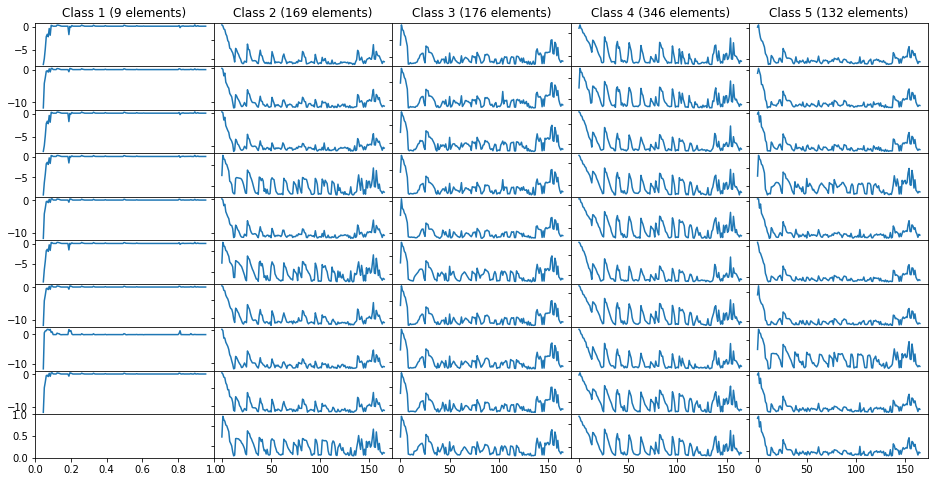

In [22]:
pylab.rcParams['figure.figsize'] = (16, 8)
plot_data(actual_dataTest, res)

## Clustering Evaluation

In [23]:
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score, adjusted_mutual_info_score, homogeneity_score, completeness_score, v_measure_score, fowlkes_mallows_score

def purity(y_true, y_pred):
    cm = contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(cm, axis=0)) / np.sum(cm) 

def DTWDistance(s1,s2,w=None):
        '''
        Calculates dynamic time warping Euclidean distance between two
        sequences. Option to enforce locality constraint for window w.
        '''
        DTW={}
        if w:
            w = max(w, abs(len(s1)-len(s2)))
            for i in range(-1,len(s1)):
                for j in range(-1,len(s2)):
                    DTW[(i, j)] = float('inf')

        else:
            for i in range(len(s1)):
                DTW[(i, -1)] = float('inf')
            for i in range(len(s2)):
                DTW[(-1, i)] = float('inf')
        DTW[(-1, -1)] = 0
        for i in range(len(s1)):
            if w:
                for j in range(max(0, i-w), min(len(s2), i+w)):
                    dist= (s1[i]-s2[j])**2
                    DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
            else:
                for j in range(len(s2)):
                    dist= (s1[i]-s2[j])**2
                    DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
        print("Done")
        return np.sqrt(DTW[len(s1)-1, len(s2)-1])
    
ground_labels =[ int(lt) + 1 for lt in actual_labelsTest ]

# Dunn Index is heavy and good for small datasets. Not used

# Misura la densità del clustering, ovvero quanto un sample è simile agli altri punto dello stesso cluster 
# e quanto bene dista dal cluster più vicino usando una metrica di similarità (euclidea, cosine, ecc).
# Questo score è la media di tutti i silhouette score di ciascun sample
# DTW is fine for TS but it takes too long
ss = silhouette_score(actual_dataTest, res, metric='euclidean')
print("Silhouette score", ss)

# DB: Misura la separazione tra cluster, compiendo una media artimetica delle similarità tra coppie di cluster più simili
# , usandodi una misura di similarità tra cluster ad hoc che mette a rapporto la somma dei diametri 
# dei cluster (media distanza euclidea intra-cluster) e la distanza euclidea tra i rispettivi centroidi.
# Più tende a 0 meglio è. Fvorisce cluster densi e ben distanti 
# Più veloce di silhouette ma limitato alla distanza euclidea
db = davies_bouldin_score(actual_dataTest, res)
print("Davies Bouldin", db)

# Righe le label e colonne i cluster
cm = contingency_matrix(ground_labels, res)
print("Contingency Matrix")
print(cm)

# Media tra tutti i cluster del numero di sample della label più presente di ciascun cluster.
# Da' una misura di quanto bene il clustering copre il labelling. Se è 1, il clustering ha coperto tutte le label
# , anche ricorrendo ad un numero di cluster maggiore delle classi
pur = purity(ground_labels, res)
print("Purity: ", pur)

# ARI: fix dell'RI, che mette a rapporto il numero di true (se due sample sono nello stesso cluster allora hanno la stessa label 
# + se due sample sono in cluster diversi allora hanno diversa label) sul numero totaale di coppie non ordinate di sample
# va bene quando si vuole un clustering molto fedele al labelling del dataset. Valida per dataset i cui sample appartengono a classi ben distanti.
# Immune al random labelling: https://scikit-learn.org/stable/auto_examples/cluster/plot_adjusted_for_chance_measures.html#sphx-glr-auto-examples-cluster-plot-adjusted-for-chance-measures-py
# Rule of thumb: Use ARI when the ground truth clustering has large equal sized clusters
ars = adjusted_rand_score(ground_labels, res)
print("Adjusted Rand Index: ", ars)

# FMS: Media geometrica di precision e recall pairwise
fms = fowlkes_mallows_score(ground_labels, res)
print("Fowlkes-Mallows score: ", fms)

# AMIS: fix del MIS, basata sull'entropia di Von Neuman, calcolata per le label e per i cluster
# Immune al random labelling
# Rule of thumb: Usa AMI when the ground truth clustering is unbalanced and there exist small clusters
amis = adjusted_mutual_info_score(ground_labels, res, average_method='arithmetic')
print("Adjusted Mutual Information: ", amis)

# Media armonica di Homogeneity e Completeness. 
# Homogeneity: Quanto un cluster ha sample di una sola label
# Completeness: Quanto i sample di una label stanno in un solo cluster
# Entrambi basati sull'entropia di Von Neumann
# Debole al random clustering con alto numero di cluster. Non buono con dataset piccoli e/o grande numero di cluster
vm = v_measure_score(ground_labels, res)
print("V-Measure: ", vm)

Silhouette score 0.2530562209900644
Davies Bouldin 1.857425016869034
Contingency Matrix
[[  9  28  30  88  30]
 [  0  52  48  91  27]
 [  0  89  98 167  75]]
Purity:  0.5264423076923077
Adjusted Rand Index:  -0.0028935870030435827
Fowlkes-Mallows score:  0.3275685239252221
Adjusted Mutual Information:  0.01542016336895556
V-Measure:  0.0195441336887912


## Visualize latent vector on PCA and tSNE

In [16]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

def plot_z_run(z_run, label, ):
    f1, ax1 = plt.subplots(2, 1)

    # First fit a PCA
    PCA_model = TruncatedSVD(n_components=3).fit(z_run)
    z_run_reduced = PCA_model.transform(z_run)
    ax1[0].scatter(z_run_reduced[:, 0], z_run_reduced[:, 1], c=label, marker='*', linewidths=0)
    ax1[0].set_title('PCA on z_run')

    # THen fit a tSNE
    tSNE_model = TSNE(verbose=2, perplexity=80, min_grad_norm=1E-12, n_iter=3000)
    z_run_tsne = tSNE_model.fit_transform(z_run)
    ax1[1].scatter(z_run_tsne[:, 0], z_run_tsne[:, 1], c=label, marker='*', linewidths=0)
    ax1[1].set_title('tSNE on z_run')

    plt.show()
    return

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 832 samples in 0.001s...
[t-SNE] Computed neighbors for 832 samples in 0.051s...
[t-SNE] Computed conditional probabilities for sample 832 / 832
[t-SNE] Mean sigma: 0.206297
[t-SNE] Computed conditional probabilities in 0.077s
[t-SNE] Iteration 50: error = 50.0382118, gradient norm = 0.2592773 (50 iterations in 0.458s)
[t-SNE] Iteration 100: error = 47.4722328, gradient norm = 0.2273977 (50 iterations in 0.430s)
[t-SNE] Iteration 150: error = 47.1932030, gradient norm = 0.2205034 (50 iterations in 0.410s)
[t-SNE] Iteration 200: error = 47.1039963, gradient norm = 0.2170930 (50 iterations in 0.427s)
[t-SNE] Iteration 250: error = 47.1228294, gradient norm = 0.2134070 (50 iterations in 0.419s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.122829
[t-SNE] Iteration 300: error = 0.2457715, gradient norm = 0.0005732 (50 iterations in 0.396s)
[t-SNE] Iteration 350: error = 0.2245122, gradient norm = 0.0001054 

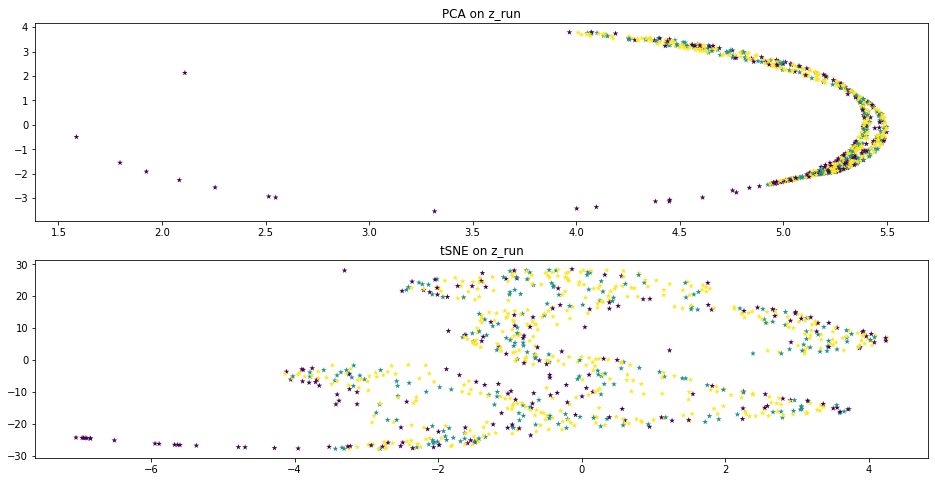

In [17]:
# Extract the latent space coordinates of the validation set
start = 0
label = []  # The label to save to visualize the latent space
z_run = []

while start + batch_size < Nval:
    run_ind = range(start, start + batch_size)
    z_mu_fetch = sess.run(model.z_mu, feed_dict={model.x: dataTest[run_ind], model.keep_prob: 1.0})
    z_run.append(z_mu_fetch)
    start += batch_size

z_run = np.concatenate(z_run, axis=0)
label = labelsTest[:start]

plot_z_run(z_run, label)